## Importação de bibliotecas

In [1]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import time
import os
import copy
from sklearn.metrics import confusion_matrix

plt.ion()   # interactive mode

# connect drive
from google.colab import drive
drive.mount('/content/gdrive')

!ls '/content/gdrive/MyDrive/2022-1Semestre/Data_P4_DL/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
test  train  val


In [2]:
import matplotlib.pyplot as plt

## Carregando os dados (imagens e rótulos) usando o DataLoader


In [24]:
# Data augmentation and normalization for training
'''
data_transforms = {
    'train': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize((170,170)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(5),
        transforms.ToTensor(),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1)
    ]),
    'val': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize((170,170)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(5),
        transforms.ToTensor(),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1)
    ]),
    'test': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize((170,170)),
        transforms.ToTensor(),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1)
    ]),
}
'''
data_transforms = {
    'train': transforms.Compose([
        
       
        transforms.Resize((170,170)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
        transforms.RandomRotation(90),
        transforms.ColorJitter(brightness=(0.5, 1.2),contrast=(0.8,1.2)),
        transforms.RandomAdjustSharpness(2),
        transforms.ToTensor(),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1)
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
        transforms.RandomRotation(90),
        transforms.ColorJitter(brightness=(0.5, 1.2),contrast=(0.8,1.2)),
        transforms.RandomAdjustSharpness(2),
        transforms.ToTensor(),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1)
    ]),
    'test': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize((170,170)),
        transforms.ToTensor(),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1)
    ]),
}

data_dir = '/content/gdrive/MyDrive/2022-1Semestre/Data_P4_DL/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Visualizando algumas imagens (one batch)

Batch of training data


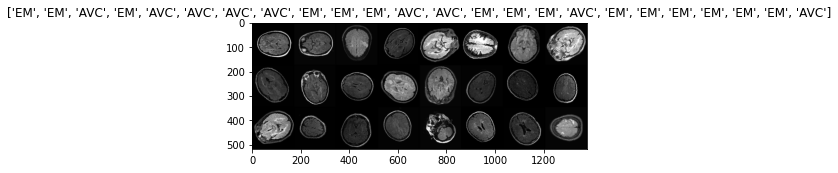

min =  0.0
median =  0.019607844
mean =  0.14797443
max =  1.0
Batch of validation data


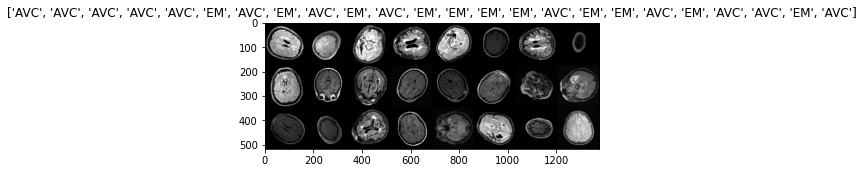

min =  0.0
median =  0.019607844
mean =  0.17748994
max =  1.0
Batch of test data


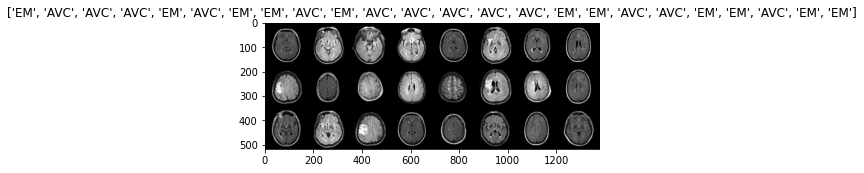

min =  0.0
median =  0.003921569
mean =  0.18364055
max =  0.99607843


In [25]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))


print('Batch of validation data')
inputs, classes = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

print('Batch of test data')
inputs, classes = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

## Treinamento

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc)
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc)
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Definindo parâmetros de treinamento. Foi escolhida a arquitetura ResNet18 não pré-treinada.

In [ ]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2 (number of classes).
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device) #send the model to GPU if it is available or CPU otherwise

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.0008, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.000005, momentum=0.9)

# Decay LR by a factor of "gamma" every "step_size" epochs
# https://pytorch.org/docs/stable/optim.html
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)

In [ ]:
# print(model) # show CNN architecture

summary(model, (3, 170, 170)) # summarize the model 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 85, 85]           9,408
       BatchNorm2d-2           [-1, 64, 85, 85]             128
              ReLU-3           [-1, 64, 85, 85]               0
         MaxPool2d-4           [-1, 64, 43, 43]               0
            Conv2d-5           [-1, 64, 43, 43]          36,864
       BatchNorm2d-6           [-1, 64, 43, 43]             128
              ReLU-7           [-1, 64, 43, 43]               0
            Conv2d-8           [-1, 64, 43, 43]          36,864
       BatchNorm2d-9           [-1, 64, 43, 43]             128
             ReLU-10           [-1, 64, 43, 43]               0
       BasicBlock-11           [-1, 64, 43, 43]               0
           Conv2d-12           [-1, 64, 43, 43]          36,864
      BatchNorm2d-13           [-1, 64, 43, 43]             128
             ReLU-14           [-1, 64,

Realizando o treinamento

###Normalização e data augmentation

In [ ]:
LOSS_train_it = []
LOSS_val_it = []
ACC_train_it = []
ACC_val_it = []

# model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
#                        num_epochs=200)
for i in range(10):
  LOSS_train = []
  LOSS_val = []
  ACC_train = []
  ACC_val = []
  model = models.resnet18(pretrained=False)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
  model = model.to(device) 

  criterion = nn.CrossEntropyLoss()
  optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)

  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)
  model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=100)
  LOSS_train_it.append(LOSS_train)
  LOSS_val_it.append(LOSS_val)
  ACC_train_it.append(ACC_train)
  ACC_val_it.append(ACC_val)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 4/99
----------
train Loss: 0.5481 Acc: 0.7771
val Loss: 0.5362 Acc: 0.7308

Epoch 5/99
----------
train Loss: 0.5228 Acc: 0.8284
val Loss: 0.5090 Acc: 0.7802

Epoch 6/99
----------
train Loss: 0.5052 Acc: 0.8481
val Loss: 0.4976 Acc: 0.8077

Epoch 7/99
----------
train Loss: 0.4773 Acc: 0.8363
val Loss: 0.4860 Acc: 0.7637

Epoch 8/99
----------
train Loss: 0.4533 Acc: 0.8560
val Loss: 0.4579 Acc: 0.7912

Epoch 9/99
----------
train Loss: 0.4382 Acc: 0.8659
val Loss: 0.4399 Acc: 0.8242

Epoch 10/99
----------
train Loss: 0.4094 Acc: 0.8955
val Loss: 0.4299 Acc: 0.8516

Epoch 11/99
----------
train Loss: 0.3991 Acc: 0.8797
val Loss: 0.4161 Acc: 0.8516

Epoch 12/99
----------
train Loss: 0.3771 Acc: 0.8895
val Loss: 0.4083 Acc: 0.8516

Epoch 13/99
----------
train Loss: 0.3629 Acc: 0.8955
val Loss: 0.3962 Acc: 0.8571

Epoch 14/99
----------
train Loss: 0.3523 Acc: 0.8817
val Loss: 0.3950 Acc: 0.8516

Epoch 15/99
----------


In [ ]:
ACC_train_mean = []
ACC_val_mean = []
LOSS_train_mean = []
LOSS_val_mean = []
for i in range(len(ACC_train_it[0])):
  ACC_train_ep = []
  ACC_val_ep = []
  LOSS_train_ep = []
  LOSS_val_ep = []
  for j in range(len(ACC_train_it)):
    ACC_train_ep.append(ACC_train_it[j][i].item())
    ACC_val_ep.append(ACC_val_it[j][i].item())
    LOSS_train_ep.append(LOSS_train_it[j][i])
    LOSS_val_ep.append(LOSS_val_it[j][i])
  #print(ACC_train_ep)
  ACC_train_mean.append(np.mean(ACC_train_ep))
  #print(np.std(ACC_train_ep))
  ACC_val_mean.append(np.mean(ACC_val_ep))
  LOSS_train_mean.append(np.mean(LOSS_train_ep))
  LOSS_val_mean.append(np.mean(LOSS_val_ep))


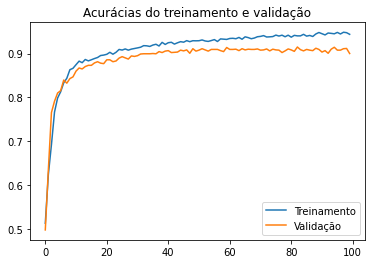

In [ ]:
plt.plot(ACC_train_mean, label="Treinamento")
plt.plot(ACC_val_mean, label="Validação")
plt.title("Acurácias do treinamento e validação")
plt.legend()
plt.show()

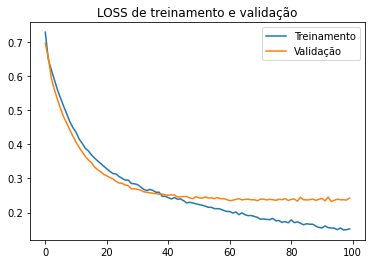

In [ ]:
plt.plot(LOSS_train_mean, label = "Treinamento")
plt.plot(LOSS_val_mean, label="Validação")
plt.title("LOSS de treinamento e validação")
plt.legend()
plt.show()

Treinamento até a 30ª época

In [ ]:
LOSS_train_it = []
LOSS_val_it = []
ACC_train_it = []
ACC_val_it = []

# model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
#                        num_epochs=200)
for i in range(10):
  LOSS_train = []
  LOSS_val = []
  ACC_train = []
  ACC_val = []
  model = models.resnet18(pretrained=False)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
  model = model.to(device) 

  criterion = nn.CrossEntropyLoss()
  optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)

  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)
  model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=30)
  LOSS_train_it.append(LOSS_train)
  LOSS_val_it.append(LOSS_val)
  ACC_train_it.append(ACC_train)
  ACC_val_it.append(ACC_val)

Epoch 0/29
----------
train Loss: 0.7002 Acc: 0.4892
val Loss: 0.6293 Acc: 0.6484

Epoch 1/29
----------
train Loss: 0.6580 Acc: 0.6805
val Loss: 0.6160 Acc: 0.7143

Epoch 2/29
----------
train Loss: 0.6122 Acc: 0.7456
val Loss: 0.5587 Acc: 0.8132

Epoch 3/29
----------
train Loss: 0.5784 Acc: 0.7199
val Loss: 0.5358 Acc: 0.8132

Epoch 4/29
----------
train Loss: 0.5498 Acc: 0.8166
val Loss: 0.5137 Acc: 0.8187

Epoch 5/29
----------
train Loss: 0.5199 Acc: 0.8323
val Loss: 0.4852 Acc: 0.8352

Epoch 6/29
----------
train Loss: 0.4942 Acc: 0.8343
val Loss: 0.4446 Acc: 0.8297

Epoch 7/29
----------
train Loss: 0.4865 Acc: 0.8245
val Loss: 0.4153 Acc: 0.8462

Epoch 8/29
----------
train Loss: 0.4659 Acc: 0.8462
val Loss: 0.4003 Acc: 0.8516

Epoch 9/29
----------
train Loss: 0.4415 Acc: 0.8580
val Loss: 0.3910 Acc: 0.8462

Epoch 10/29
----------
train Loss: 0.4503 Acc: 0.8540
val Loss: 0.3796 Acc: 0.8571

Epoch 11/29
----------
train Loss: 0.4162 Acc: 0.8757
val Loss: 0.3741 Acc: 0.8626

Ep

In [ ]:
ACC_train_mean = []
ACC_val_mean = []
LOSS_train_mean = []
LOSS_val_mean = []
for i in range(len(ACC_train_it[0])):
  ACC_train_ep = []
  ACC_val_ep = []
  LOSS_train_ep = []
  LOSS_val_ep = []
  for j in range(len(ACC_train_it)):
    ACC_train_ep.append(ACC_train_it[j][i].item())
    ACC_val_ep.append(ACC_val_it[j][i].item())
    LOSS_train_ep.append(LOSS_train_it[j][i])
    LOSS_val_ep.append(LOSS_val_it[j][i])
  #print(ACC_train_ep)
  ACC_train_mean.append(np.mean(ACC_train_ep))
  #print(np.std(ACC_train_ep))
  ACC_val_mean.append(np.mean(ACC_val_ep))
  LOSS_train_mean.append(np.mean(LOSS_train_ep))
  LOSS_val_mean.append(np.mean(LOSS_val_ep))


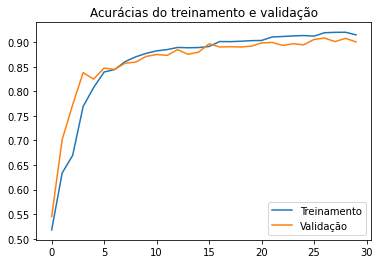

In [ ]:
plt.plot(ACC_train_mean, label="Treinamento")
plt.plot(ACC_val_mean, label="Validação")
plt.title("Acurácias do treinamento e validação")
plt.legend()
plt.show()

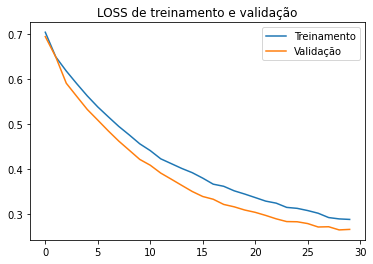

In [ ]:
plt.plot(LOSS_train_mean, label = "Treinamento")
plt.plot(LOSS_val_mean, label="Validação")
plt.title("LOSS de treinamento e validação")
plt.legend()
plt.show()

### Sem normalização, com data augmentation

In [ ]:
LOSS_train_it = []
LOSS_val_it = []
ACC_train_it = []
ACC_val_it = []

# model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
#                        num_epochs=200)
for i in range(10):
  LOSS_train = []
  LOSS_val = []
  ACC_train = []
  ACC_val = []
  model = models.resnet18(pretrained=False)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
  model = model.to(device) 

  criterion = nn.CrossEntropyLoss()
  optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)

  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)
  model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=100)
  LOSS_train_it.append(LOSS_train)
  LOSS_val_it.append(LOSS_val)
  ACC_train_it.append(ACC_train)
  ACC_val_it.append(ACC_val)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 4/99
----------
train Loss: 0.5510 Acc: 0.8225
val Loss: 0.5275 Acc: 0.8407

Epoch 5/99
----------
train Loss: 0.5208 Acc: 0.8087
val Loss: 0.4823 Acc: 0.8407

Epoch 6/99
----------
train Loss: 0.5052 Acc: 0.8028
val Loss: 0.4712 Acc: 0.8407

Epoch 7/99
----------
train Loss: 0.4823 Acc: 0.8679
val Loss: 0.4633 Acc: 0.8571

Epoch 8/99
----------
train Loss: 0.4650 Acc: 0.8698
val Loss: 0.4449 Acc: 0.8462

Epoch 9/99
----------
train Loss: 0.4513 Acc: 0.8580
val Loss: 0.4013 Acc: 0.8791

Epoch 10/99
----------
train Loss: 0.4275 Acc: 0.8698
val Loss: 0.3931 Acc: 0.8626

Epoch 11/99
----------
train Loss: 0.4225 Acc: 0.8619
val Loss: 0.3879 Acc: 0.8571

Epoch 12/99
----------
train Loss: 0.4041 Acc: 0.8797
val Loss: 0.3782 Acc: 0.8516

Epoch 13/99
----------
train Loss: 0.3944 Acc: 0.8856
val Loss: 0.3637 Acc: 0.8681

Epoch 14/99
----------
train Loss: 0.3946 Acc: 0.8797
val Loss: 0.3647 Acc: 0.8462

Epoch 15/99
----------


In [ ]:
ACC_train_mean = []
ACC_val_mean = []
LOSS_train_mean = []
LOSS_val_mean = []
for i in range(len(ACC_train_it[0])):
  ACC_train_ep = []
  ACC_val_ep = []
  LOSS_train_ep = []
  LOSS_val_ep = []
  for j in range(len(ACC_train_it)):
    ACC_train_ep.append(ACC_train_it[j][i].item())
    ACC_val_ep.append(ACC_val_it[j][i].item())
    LOSS_train_ep.append(LOSS_train_it[j][i])
    LOSS_val_ep.append(LOSS_val_it[j][i])
  #print(ACC_train_ep)
  ACC_train_mean.append(np.mean(ACC_train_ep))
  #print(np.std(ACC_train_ep))
  ACC_val_mean.append(np.mean(ACC_val_ep))
  LOSS_train_mean.append(np.mean(LOSS_train_ep))
  LOSS_val_mean.append(np.mean(LOSS_val_ep))


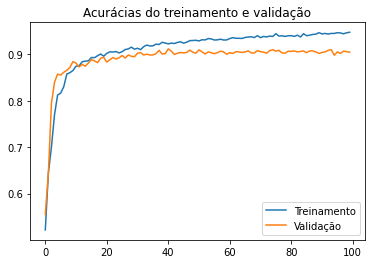

In [ ]:
plt.plot(ACC_train_mean, label="Treinamento")
plt.plot(ACC_val_mean, label="Validação")
plt.title("Acurácias do treinamento e validação")
plt.legend()
plt.show()

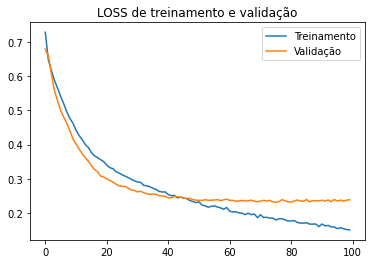

In [ ]:
plt.plot(LOSS_train_mean, label = "Treinamento")
plt.plot(LOSS_val_mean, label="Validação")
plt.title("LOSS de treinamento e validação")
plt.legend()
plt.show()

Treinando até a 30ª época

In [ ]:
LOSS_train_it = []
LOSS_val_it = []
ACC_train_it = []
ACC_val_it = []

# model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
#                        num_epochs=200)
for i in range(10):
  LOSS_train = []
  LOSS_val = []
  ACC_train = []
  ACC_val = []
  model = models.resnet18(pretrained=False)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
  model = model.to(device) 

  criterion = nn.CrossEntropyLoss()
  optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)

  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)
  model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=30)
  LOSS_train_it.append(LOSS_train)
  LOSS_val_it.append(LOSS_val)
  ACC_train_it.append(ACC_train)
  ACC_val_it.append(ACC_val)

Epoch 0/29
----------
train Loss: 0.6881 Acc: 0.5661
val Loss: 0.7285 Acc: 0.3516

Epoch 1/29
----------
train Loss: 0.6652 Acc: 0.6036
val Loss: 0.7092 Acc: 0.3681

Epoch 2/29
----------
train Loss: 0.6413 Acc: 0.6233
val Loss: 0.6262 Acc: 0.7418

Epoch 3/29
----------
train Loss: 0.6185 Acc: 0.6252
val Loss: 0.5848 Acc: 0.7363

Epoch 4/29
----------
train Loss: 0.5978 Acc: 0.7594
val Loss: 0.5808 Acc: 0.8132

Epoch 5/29
----------
train Loss: 0.5775 Acc: 0.7673
val Loss: 0.5426 Acc: 0.7527

Epoch 6/29
----------
train Loss: 0.5508 Acc: 0.7771
val Loss: 0.5286 Acc: 0.8407

Epoch 7/29
----------
train Loss: 0.5291 Acc: 0.8540
val Loss: 0.5045 Acc: 0.8681

Epoch 8/29
----------
train Loss: 0.5135 Acc: 0.8935
val Loss: 0.4847 Acc: 0.8901

Epoch 9/29
----------
train Loss: 0.4901 Acc: 0.8738
val Loss: 0.4552 Acc: 0.8846

Epoch 10/29
----------
train Loss: 0.4588 Acc: 0.8836
val Loss: 0.4385 Acc: 0.8846

Epoch 11/29
----------
train Loss: 0.4440 Acc: 0.8974
val Loss: 0.4206 Acc: 0.9011

Ep

In [ ]:
ACC_train_mean = []
ACC_val_mean = []
LOSS_train_mean = []
LOSS_val_mean = []
for i in range(len(ACC_train_it[0])):
  ACC_train_ep = []
  ACC_val_ep = []
  LOSS_train_ep = []
  LOSS_val_ep = []
  for j in range(len(ACC_train_it)):
    ACC_train_ep.append(ACC_train_it[j][i].item())
    ACC_val_ep.append(ACC_val_it[j][i].item())
    LOSS_train_ep.append(LOSS_train_it[j][i])
    LOSS_val_ep.append(LOSS_val_it[j][i])
  #print(ACC_train_ep)
  ACC_train_mean.append(np.mean(ACC_train_ep))
  #print(np.std(ACC_train_ep))
  ACC_val_mean.append(np.mean(ACC_val_ep))
  LOSS_train_mean.append(np.mean(LOSS_train_ep))
  LOSS_val_mean.append(np.mean(LOSS_val_ep))


In [ ]:
plt.plot(ACC_train_mean, label="Treinamento")
plt.plot(ACC_val_mean, label="Validação")
plt.title("Acurácias do treinamento e validação")
plt.legend()
plt.show()

NameError: ignored

In [ ]:
plt.plot(LOSS_train_mean, label = "Treinamento")
plt.plot(LOSS_val_mean, label="Validação")
plt.title("LOSS de treinamento e validação")
plt.legend()
plt.show()

###Sem normalização e sem data augmentation

In [ ]:
LOSS_train_it = []
LOSS_val_it = []
ACC_train_it = []
ACC_val_it = []

# model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
#                        num_epochs=200)
for i in range(10):
  LOSS_train = []
  LOSS_val = []
  ACC_train = []
  ACC_val = []
  model = models.resnet18(pretrained=False)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
  model = model.to(device) 

  criterion = nn.CrossEntropyLoss()
  optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)

  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)
  model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=50)
  LOSS_train_it.append(LOSS_train)
  LOSS_val_it.append(LOSS_val)
  ACC_train_it.append(ACC_train)
  ACC_val_it.append(ACC_val)

Epoch 0/49
----------
train Loss: 0.7486 Acc: 0.4694
val Loss: 0.7226 Acc: 0.3516

Epoch 1/49
----------
train Loss: 0.6509 Acc: 0.6627
val Loss: 0.6968 Acc: 0.4396

Epoch 2/49
----------
train Loss: 0.6149 Acc: 0.7318
val Loss: 0.6194 Acc: 0.7692

Epoch 3/49
----------
train Loss: 0.5893 Acc: 0.8047
val Loss: 0.5764 Acc: 0.8352

Epoch 4/49
----------
train Loss: 0.5693 Acc: 0.7890
val Loss: 0.5508 Acc: 0.8462

Epoch 5/49
----------
train Loss: 0.5412 Acc: 0.8304
val Loss: 0.5304 Acc: 0.8242

Epoch 6/49
----------
train Loss: 0.5205 Acc: 0.8481
val Loss: 0.5073 Acc: 0.8352

Epoch 7/49
----------
train Loss: 0.5045 Acc: 0.8817
val Loss: 0.4879 Acc: 0.8462

Epoch 8/49
----------
train Loss: 0.4784 Acc: 0.8698
val Loss: 0.4627 Acc: 0.8516

Epoch 9/49
----------
train Loss: 0.4579 Acc: 0.8698
val Loss: 0.4525 Acc: 0.8516

Epoch 10/49
----------
train Loss: 0.4472 Acc: 0.8698
val Loss: 0.4367 Acc: 0.8516

Epoch 11/49
----------
train Loss: 0.4324 Acc: 0.8817
val Loss: 0.4225 Acc: 0.8516

Ep

In [ ]:
ACC_train_mean = []
ACC_val_mean = []
LOSS_train_mean = []
LOSS_val_mean = []
for i in range(len(ACC_train_it[0])):
  ACC_train_ep = []
  ACC_val_ep = []
  LOSS_train_ep = []
  LOSS_val_ep = []
  for j in range(len(ACC_train_it)):
    ACC_train_ep.append(ACC_train_it[j][i].item())
    ACC_val_ep.append(ACC_val_it[j][i].item())
    LOSS_train_ep.append(LOSS_train_it[j][i])
    LOSS_val_ep.append(LOSS_val_it[j][i])
  #print(ACC_train_ep)
  ACC_train_mean.append(np.mean(ACC_train_ep))
  #print(np.std(ACC_train_ep))
  ACC_val_mean.append(np.mean(ACC_val_ep))
  LOSS_train_mean.append(np.mean(LOSS_train_ep))
  LOSS_val_mean.append(np.mean(LOSS_val_ep))

In [ ]:
plt.plot(ACC_train_mean, label="Treinamento")
plt.plot(ACC_val_mean, label="Validação")
plt.title("Acurácias do treinamento e validação")
plt.legend()
plt.show()

In [ ]:
plt.plot(LOSS_train_mean, label = "Treinamento")
plt.plot(LOSS_val_mean, label="Validação")
plt.title("LOSS de treinamento e validação")
plt.legend()
plt.show()

##Sem normalização, com novo data augmentation

In [ ]:
LOSS_train_it = []
LOSS_val_it = []
ACC_train_it = []
ACC_val_it = []

# model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
#                        num_epochs=200)
for i in range(10):
  LOSS_train = []
  LOSS_val = []
  ACC_train = []
  ACC_val = []
  model = models.resnet18(pretrained=False)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
  model = model.to(device) 

  criterion = nn.CrossEntropyLoss()
  optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)

  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)
  model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=50)
  LOSS_train_it.append(LOSS_train)
  LOSS_val_it.append(LOSS_val)
  ACC_train_it.append(ACC_train)
  ACC_val_it.append(ACC_val)

Epoch 0/49
----------
train Loss: 0.7008 Acc: 0.5207
val Loss: 0.6878 Acc: 0.6484

Epoch 1/49
----------
train Loss: 0.6711 Acc: 0.5799
val Loss: 0.6668 Acc: 0.6484

Epoch 2/49
----------
train Loss: 0.6483 Acc: 0.6469
val Loss: 0.6107 Acc: 0.7637

Epoch 3/49
----------
train Loss: 0.6400 Acc: 0.6272
val Loss: 0.5901 Acc: 0.7253

Epoch 4/49
----------
train Loss: 0.6129 Acc: 0.6864
val Loss: 0.5788 Acc: 0.7582

Epoch 5/49
----------
train Loss: 0.5971 Acc: 0.7258
val Loss: 0.5514 Acc: 0.8022

Epoch 6/49
----------
train Loss: 0.5936 Acc: 0.7318
val Loss: 0.5290 Acc: 0.8352

Epoch 7/49
----------
train Loss: 0.5806 Acc: 0.7278
val Loss: 0.5166 Acc: 0.8462

Epoch 8/49
----------
train Loss: 0.5682 Acc: 0.7416
val Loss: 0.5256 Acc: 0.7857

Epoch 9/49
----------
train Loss: 0.5524 Acc: 0.7416
val Loss: 0.5018 Acc: 0.8077

Epoch 10/49
----------
train Loss: 0.5383 Acc: 0.7416
val Loss: 0.4839 Acc: 0.8352

Epoch 11/49
----------
train Loss: 0.5289 Acc: 0.7673
val Loss: 0.4841 Acc: 0.8297

Ep

In [ ]:
ACC_train_mean = []
ACC_val_mean = []
LOSS_train_mean = []
LOSS_val_mean = []
for i in range(len(ACC_train_it[0])):
  ACC_train_ep = []
  ACC_val_ep = []
  LOSS_train_ep = []
  LOSS_val_ep = []
  for j in range(len(ACC_train_it)):
    ACC_train_ep.append(ACC_train_it[j][i].item())
    ACC_val_ep.append(ACC_val_it[j][i].item())
    LOSS_train_ep.append(LOSS_train_it[j][i])
    LOSS_val_ep.append(LOSS_val_it[j][i])
  #print(ACC_train_ep)
  ACC_train_mean.append(np.mean(ACC_train_ep))
  #print(np.std(ACC_train_ep))
  ACC_val_mean.append(np.mean(ACC_val_ep))
  LOSS_train_mean.append(np.mean(LOSS_train_ep))
  LOSS_val_mean.append(np.mean(LOSS_val_ep))

In [ ]:
plt.plot(ACC_train_mean, label="Treinamento")
plt.plot(ACC_val_mean, label="Validação")
plt.title("Acurácias do treinamento e validação")
plt.legend()
plt.show()

In [ ]:
plt.plot(LOSS_train_mean, label = "Treinamento")
plt.plot(LOSS_val_mean, label="Validação")
plt.title("LOSS de treinamento e validação")
plt.legend()
plt.show()

Show training

##Visualiando as predições do modelo para o conjunto de teste

###Normalização e data augmentation

In [ ]:
def predic_model(model, plot_img = False, num_images=24):
    was_training = model.training
    model.eval()
    images_so_far = 0
    PREDICTED = []
    LABEL = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
              images_so_far += 1
              PREDICTED.append(class_names[preds[j]])
              LABEL.append(class_names[labels[j]])
              if plot_img:
                plt.figure()
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                plt.axis('off')
                plt.title('predicted: {} - label: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                plt.plot()

              if images_so_far == num_images:
                model.train(mode=was_training)
                # break
                return PREDICTED, LABEL

        model.train(mode=was_training)

    return PREDICTED, LABEL

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model, plot_img = False, num_images=test_group_len)

In [ ]:
test_AVC_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'AVC'])
test_EM_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'EM'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_EM_size # Sensibilidade: é a razão entre as imagens com EM classificadas corretamente e o total de imagens com EM (Verdadeiros positivos ÷ EM)
Especificidade = CM_test[0,0]/test_AVC_size # Especificidade: é a razão entre as imagens com AVC classificadas corretamente e o total de imagens com AVC (Verdadeiros negativos ÷ AVC)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)




 Conjunto de Teste 

labels =  ['AVC', 'EM', 'AVC', 'EM', 'EM', 'EM', 'EM', 'EM', 'AVC', 'AVC', 'EM', 'AVC', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'AVC', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'AVC']
predições =  ['EM', 'EM', 'AVC', 'EM', 'EM', 'EM', 'EM', 'EM', 'AVC', 'AVC', 'EM', 'AVC', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'AVC', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'AVC']
matriz de confusão = 
 [[11  1]
 [ 0 14]]
Sensibilidade =  1.0
Especificidade =  0.9166666666666666
acc =  0.9615384615384616


###Sem normalização e com data augmentation

In [ ]:
def predic_model(model, plot_img = False, num_images=24):
    was_training = model.training
    model.eval()
    images_so_far = 0
    PREDICTED = []
    LABEL = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
              images_so_far += 1
              PREDICTED.append(class_names[preds[j]])
              LABEL.append(class_names[labels[j]])
              if plot_img:
                plt.figure()
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                plt.axis('off')
                plt.title('predicted: {} - label: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                plt.plot()

              if images_so_far == num_images:
                model.train(mode=was_training)
                # break
                return PREDICTED, LABEL

        model.train(mode=was_training)

    return PREDICTED, LABEL

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model, plot_img = False, num_images=test_group_len)

In [ ]:
test_AVC_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'AVC'])
test_EM_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'EM'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_EM_size # Sensibilidade: é a razão entre as imagens com EM classificadas corretamente e o total de imagens com EM (Verdadeiros positivos ÷ EM)
Especificidade = CM_test[0,0]/test_AVC_size # Especificidade: é a razão entre as imagens com AVC classificadas corretamente e o total de imagens com AVC (Verdadeiros negativos ÷ AVC)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)




 Conjunto de Teste 

labels =  ['EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'AVC', 'EM', 'AVC', 'AVC', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'EM', 'AVC', 'EM', 'AVC', 'EM', 'EM', 'EM']
predições =  ['EM', 'AVC', 'EM', 'EM', 'EM', 'EM', 'EM', 'AVC', 'AVC', 'EM', 'AVC', 'AVC', 'EM', 'AVC', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'AVC', 'EM', 'AVC', 'EM', 'EM', 'EM']
matriz de confusão = 
 [[ 8  2]
 [ 0 16]]
Sensibilidade =  1.0
Especificidade =  0.8
acc =  0.9230769230769231
